Zadanie:

 Przeprowadziliśmy ankietę mającą zbadać cechy psychologiczne polskich internautów. Na wynik badania składają się dwa pliki:

1. users.csv - dane demograficzne ankietowanych oraz przeglądarka z jakiej korzystają.

2. personality.csv - profil psychologiczny ankietowanych, opisany przez 5 cech: A-E.

 
Opis cech demograficznych:

·       D01 Płeć

·       D02 Rok urodzenia

·       D03 Wykształcenie - podstawowe, zawodowe, średnie, wyższe

·       D04 Status zawodowy

·       D05 Wielkość miejscowości - wieś, do 20k, do 100k, do 500k, powyżej

·       D06 Sytuacja finansowa

·       D07 Rozmiar gospodarstwa domowego

 
Szukamy odpowiedzi na następujące pytania:

1. Czy istnieje związek pomiędzy posiadanymi przez nas informacjami o ankietowanych, a ich profilem psychologicznym?

2. Czy możemy podzielić ankietowanych na grupy osób o podobnym profilu psychologicznym? Jakie to grupy, co wyróżnia każdą z nich, jaka jest ich charakterystyka demograficzna?

 
Przeprowadź odpowiednią analizę danych. Przygotuj krótkie, wysokopoziomowe podsumowanie managementu oraz paczkę z kodem pozwalającym na odtworzenie najważniejszych wyników oraz dalszy rozwój rozwiązań 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Exploratory Data Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import eda

In [3]:
users_df = pd.read_csv('data/users.csv')
personality_df = pd.read_csv('data/personality.csv')

In [4]:
users_df.head()

,UserIdentifier,UserBrowser,D01,D02,D03,D04,D05,D06,D07
0,d2d10f362bb1d0092174a660778cbe50,Firefox 69.0 (Desktop),M,1954.0,3.0,4.0,2.0,6.0,2.0
1,083a56a91d0d1ee4e66643849133b2b3,Chrome 70.0.3538.110 (Mobile),M,1963.0,2.0,2.0,2.0,7.0,2.0
2,fdc1004b329f2aca4c81ad59c93c1be0,Chrome 77.0.3865.90 (Desktop),K,1975.0,4.0,1.0,4.0,5.0,6.0
3,8b8a4372a0f3fd3e1a1d4c531211506e,Chrome 75.0.3770.142 (Desktop),K,1991.0,3.0,2.0,4.0,5.0,4.0
4,58d0c701bf73a5949e2ee29f387fb5a2,Chrome 78.0.3904.108 (Mobile),M,2000.0,3.0,3.0,1.0,7.0,6.0


In [5]:
personality_df.head()

,UserIdentifier,A,B,C,D,E
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409


### first let's get rid of duplicated entries

In [6]:
print(f"there were {users_df.shape[0] - users_df.drop_duplicates().shape[0]} duplicated user entries" )
print(f"there were {personality_df.shape[0] - personality_df.drop_duplicates().shape[0]} duplicated personality entries" )

users_df = users_df.drop_duplicates()
personality_df = personality_df.drop_duplicates()

there were 187 duplicated user entries
there were 152 duplicated personality entries


# Data cleaning

### 1. Split 'UserBrowser' into many columns: 'Browser', 'Version', 'Device'

In [7]:
users_df[['Browser', 'Version', 'Device']] = users_df.UserBrowser.apply(lambda row: pd.Series(row.split(" ")))
users_df.Device = users_df.Device.apply(lambda row: row.strip('()'))
users_df.drop('UserBrowser', axis=1, inplace=True)
users_df.head()

,UserIdentifier,D01,D02,D03,D04,D05,D06,D07,Browser,Version,Device
0,d2d10f362bb1d0092174a660778cbe50,M,1954.0,3.0,4.0,2.0,6.0,2.0,Firefox,69.0,Desktop
1,083a56a91d0d1ee4e66643849133b2b3,M,1963.0,2.0,2.0,2.0,7.0,2.0,Chrome,70.0.3538.110,Mobile
2,fdc1004b329f2aca4c81ad59c93c1be0,K,1975.0,4.0,1.0,4.0,5.0,6.0,Chrome,77.0.3865.90,Desktop
3,8b8a4372a0f3fd3e1a1d4c531211506e,K,1991.0,3.0,2.0,4.0,5.0,4.0,Chrome,75.0.3770.142,Desktop
4,58d0c701bf73a5949e2ee29f387fb5a2,M,2000.0,3.0,3.0,1.0,7.0,6.0,Chrome,78.0.3904.108,Mobile


now, we have to convert the new columns into numerical ones

/Users/ostyk/Desktop/recovery_github/AdEmotion/eda.py:38: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  data_col.value_counts().plot('bar')


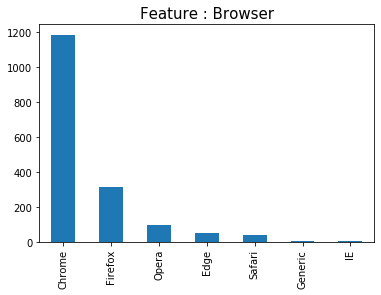

In [8]:
eda.categ_summary(users_df['Browser'])

most use chrome

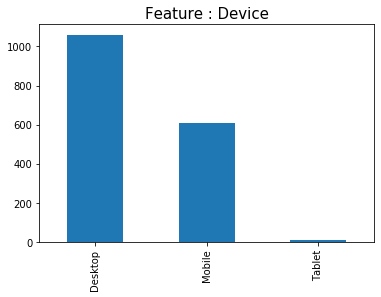

In [9]:
eda.categ_summary(users_df['Device'])

tablets are very rare

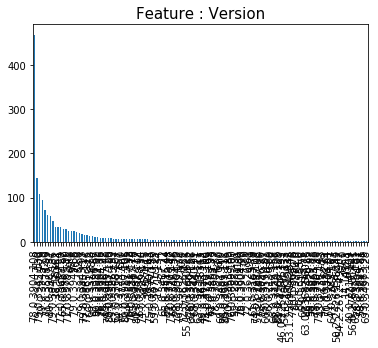

In [10]:
eda.categ_summary(users_df['Version'])

There are too many versions, and they don't really make an impact

In [11]:
users_df = users_df.drop(['Version'], axis=1)

finally we convert categorical values into numerical by using one hot encoding

In [12]:
users_df = pd.get_dummies(users_df, columns=['Browser', 'Device'])

### 2 . sex into binary

In [13]:
users_df['Sex'] = users_df['D01'].map({"M":0, "K": 1})

### 3. Change dtypes from 'float64' to 'int16'
(Columns D05-D07 have 'nan' values, hence they are left as float)

In [14]:
users_df.dtypes

UserIdentifier      object
D01                 object
D02                float64
D03                float64
D04                float64
D05                float64
D06                float64
D07                float64
Browser_Chrome       uint8
Browser_Edge         uint8
Browser_Firefox      uint8
Browser_Generic      uint8
Browser_IE           uint8
Browser_Opera        uint8
Browser_Safari       uint8
Device_Desktop       uint8
Device_Mobile        uint8
Device_Tablet        uint8
Sex                  int64
dtype: object

In [15]:
users_df = users_df.astype(dtype={'D02':np.int16, 'D03':np.int16, 'D04':np.int16})

#### check for those nan values

In [16]:
col_nan = users_df.isna().sum()
print("Column | %")
col_nan[col_nan > 0.]

Column | %


D05    1
D06    1
D07    1
dtype: int64

In [17]:
users_df[users_df['D05'].isna()]

,UserIdentifier,D01,D02,D03,D04,D05,D06,D07,Browser_Chrome,Browser_Edge,Browser_Firefox,Browser_Generic,Browser_IE,Browser_Opera,Browser_Safari,Device_Desktop,Device_Mobile,Device_Tablet,Sex
557,afe841be2dababac5a440e0c14a9f903,K,1981,4,2,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,1


only one record with unknown information, for simplicity reasons we discard it. However, if the data is scarce it should be filled with i.e. averages ofother columns if applicable

In [18]:
users_df = users_df.dropna()

### 4. Assuming that this data comes from the Polish market, we can divide the year of birth column into generations
source : https://natemat.pl/235903,do-jakiego-pokolenia-naleze-generacja-z-to-najliczniejsza-grupa-w-polsce

![docs/pokolenia.jpg](docs/pokolenia.jpg)

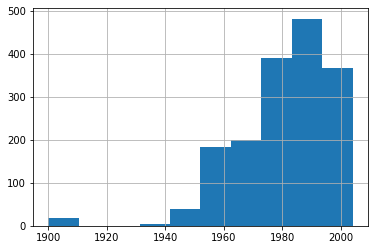

In [19]:
users_df['D02'].hist()

In [20]:
year_of_birth_mapper = {"pokolenie Z": range(1995, 2020),
                       "pokolenie Y": range(1980, 1995),
                       "pokolenie X": range(1964, 1980),
                       "pokolenie BB": range(1946, 1964),
                       "other": range(users_df['D02'].min(), 1946)}

In [21]:
users_df['Generation'] = users_df['D02'].apply(lambda x: next((k for k, v in year_of_birth_mapper.items() if x in v), 0))

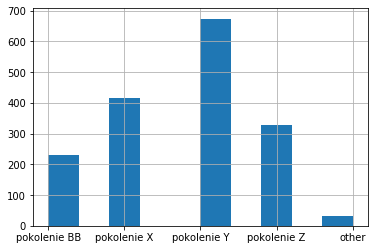

In [22]:
users_df['Generation'].hist()

this was just for show as we need to convert these into numerical form

In [23]:
year_of_birth_mapper_to_numerical = {"pokolenie Z": 5,
                                     "pokolenie Y": 4,
                                     "pokolenie X": 3,
                                     "pokolenie BB": 2,
                                     "other": 1}

In [24]:
users_df['Generation'] =  users_df['Generation'].apply(lambda x: next((v for k, v in year_of_birth_mapper_to_numerical.items() if x in k), 0))

In [25]:
users_df = users_df.rename(columns = {"D03": "Education", 
                                      "D05": "City size", 
                                      "D04": "Professional status", 
                                     "D06": "Financial_situation",
                                     "D07": "Size of Household"})

In [26]:
users_df = users_df.drop(["D01", "D02"], axis=1)

#### We can assume that the higher the number, the better the financial situation. Also this follows a normal distribution implying the wealth distribution is fairly representative of the population.

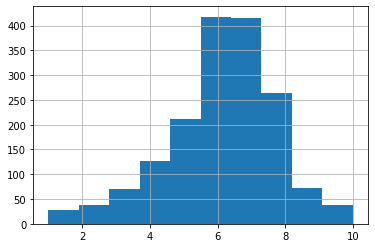

In [27]:
users_df['Financial_situation'].hist()

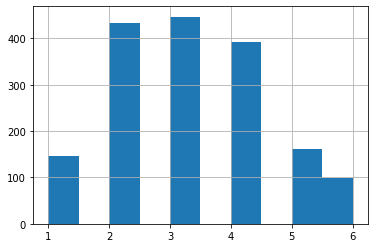

In [28]:
users_df['Size of Household'].hist()

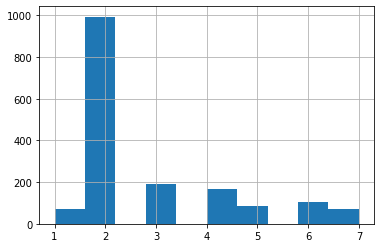

In [29]:
users_df['Professional status'].hist()

In [30]:
users_df.head()

,UserIdentifier,Education,Professional status,City size,Financial_situation,Size of Household,Browser_Chrome,Browser_Edge,Browser_Firefox,Browser_Generic,Browser_IE,Browser_Opera,Browser_Safari,Device_Desktop,Device_Mobile,Device_Tablet,Sex,Generation
0,d2d10f362bb1d0092174a660778cbe50,3,4,2.0,6.0,2.0,0,0,1,0,0,0,0,1,0,0,0,2
1,083a56a91d0d1ee4e66643849133b2b3,2,2,2.0,7.0,2.0,1,0,0,0,0,0,0,0,1,0,0,2
2,fdc1004b329f2aca4c81ad59c93c1be0,4,1,4.0,5.0,6.0,1,0,0,0,0,0,0,1,0,0,1,3
3,8b8a4372a0f3fd3e1a1d4c531211506e,3,2,4.0,5.0,4.0,1,0,0,0,0,0,0,1,0,0,1,4
4,58d0c701bf73a5949e2ee29f387fb5a2,3,3,1.0,7.0,6.0,1,0,0,0,0,0,0,0,1,0,0,5


#### end of column preprocessing

# pre-statistical analysis: 
### let's see if we have any duplicates in the form of the same user but with different variable values

In [31]:
f"there are {len(users_df['UserIdentifier'].unique())} unique identifies in the users csv"
f"there are {len(personality_df['UserIdentifier'].unique())} unique identifies in the personality csv"

user_counts = pd.DataFrame(np.unique(users_df['UserIdentifier'], return_counts=True, return_index=False, return_inverse=False)).T
user_counts = user_counts.sort_values(by=1, ascending=False)
user_counts = user_counts[user_counts[1]>1]
user_counts.columns = ['id', 'users']

personality_counts = pd.DataFrame(np.unique(personality_df['UserIdentifier'], return_counts=True, return_index=False, return_inverse=False)).T
personality_counts = personality_counts.sort_values(by=1, ascending=False)
personality_counts = personality_counts[personality_counts[1]>1]
personality_counts.columns = ['id', 'personality']

In [32]:
user_counts

,id,users
805,77f0be1043bff8c9a56eade3b14ae1d3,2
847,8015c0d8fc1e5cacfc646805a107a774,2


In [33]:
personality_counts

,id,personality
737,77f0be1043bff8c9a56eade3b14ae1d3,4
777,8015c0d8fc1e5cacfc646805a107a774,4
1035,a9708dbcb21aa7ccf7ce2de45cf9f206,2
1212,c7f107a928b95df530d54f6e0a5af971,2


#### let's conside only the users that are present in both, since we cannot evaluate anything useful in this task from only information from one table

In [34]:
user_counts.merge(personality_counts, on='id')

,id,users,personality
0,77f0be1043bff8c9a56eade3b14ae1d3,2,4
1,8015c0d8fc1e5cacfc646805a107a774,2,4


In [35]:
user_1 = '77f0be1043bff8c9a56eade3b14ae1d3'
user_2 = '8015c0d8fc1e5cacfc646805a107a774'

So we have two users with a unique user id who have more than one entry. Let's explore why that is the case

In [36]:
users_df[users_df['UserIdentifier']==user_1]

,UserIdentifier,Education,Professional status,City size,Financial_situation,Size of Household,Browser_Chrome,Browser_Edge,Browser_Firefox,Browser_Generic,Browser_IE,Browser_Opera,Browser_Safari,Device_Desktop,Device_Mobile,Device_Tablet,Sex,Generation
1408,77f0be1043bff8c9a56eade3b14ae1d3,3,2,4.0,10.0,6.0,0,1,0,0,0,0,0,1,0,0,0,4
1409,77f0be1043bff8c9a56eade3b14ae1d3,3,2,4.0,8.0,6.0,0,1,0,0,0,0,0,1,0,0,0,4


In [37]:
users_df[users_df['UserIdentifier']==user_2]

,UserIdentifier,Education,Professional status,City size,Financial_situation,Size of Household,Browser_Chrome,Browser_Edge,Browser_Firefox,Browser_Generic,Browser_IE,Browser_Opera,Browser_Safari,Device_Desktop,Device_Mobile,Device_Tablet,Sex,Generation
1488,8015c0d8fc1e5cacfc646805a107a774,2,4,1.0,6.0,2.0,0,1,0,0,0,0,0,1,0,0,1,3
1489,8015c0d8fc1e5cacfc646805a107a774,2,4,1.0,10.0,2.0,0,1,0,0,0,0,0,1,0,0,1,3


### hence we can see that this is because their financial situation has changed, let's see if this had an impact on their personality

In [38]:
personality_df[personality_df['UserIdentifier']==user_1]

,UserIdentifier,A,B,C,D,E
1255,77f0be1043bff8c9a56eade3b14ae1d3,-1.250586,1.679915,-0.005389,-0.549635,-0.251646
1256,77f0be1043bff8c9a56eade3b14ae1d3,-1.795843,0.741011,-0.006315,-0.194033,-0.254256
1257,77f0be1043bff8c9a56eade3b14ae1d3,-1.160114,1.514207,-0.078972,-0.672392,-0.095133
1258,77f0be1043bff8c9a56eade3b14ae1d3,-1.705372,0.575303,-0.079898,-0.316791,-0.097743


In [39]:
personality_df[personality_df['UserIdentifier']==user_2]

,UserIdentifier,A,B,C,D,E
1329,8015c0d8fc1e5cacfc646805a107a774,-3.087869,-0.093816,-0.404177,-0.205214,0.068431
1330,8015c0d8fc1e5cacfc646805a107a774,-3.211284,-0.375528,-0.430127,-0.219763,-0.081141
1331,8015c0d8fc1e5cacfc646805a107a774,-2.980238,-0.096443,-0.124548,-0.221593,0.053838
1332,8015c0d8fc1e5cacfc646805a107a774,-3.103653,-0.378156,-0.150498,-0.236142,-0.095734


## we can see that their psychological profile may differ slightly but due to the size of number of anomalies, we will proceed to drop them from further analysis

In [40]:
users_df = users_df[~users_df['UserIdentifier'].isin([user_1, user_2])]
personality_df = personality_df[~personality_df['UserIdentifier'].isin([user_1, user_2])]

#### personality nan values

In [41]:
nan_per = personality_df.iloc[pd.isnull(personality_df).any(1).nonzero()[0]]
print(nan_per.shape)
nan_per.head()

(37, 6)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


,UserIdentifier,A,B,C,D,E
48,ff7e34757a2f5a556900da8f256caf6c,-1.355529,NaN,-0.670744,-0.641809,0.392482
129,a114937cd1ef612737e1d6e32b167da3,-2.090893,-0.024152,NaN,-0.280436,0.236356
184,385e7c4a548e0cc7430265852959b37c,0.898997,0.973255,1.621190,-0.388284,NaN
186,c87032106f5cced05a9017bb66dc2f6f,0.050791,NaN,0.194658,1.314765,0.604076
190,e384956c34ae245c0260f36cd325c1fa,-1.211774,-0.971555,NaN,0.612637,0.065842


Hence we can fill these values with the column mean

In [42]:
personality_df[['A', 'B', 'C', 'D', 'E']] = personality_df[['A', 'B', 'C', 'D', 'E']].apply(lambda x: x.fillna(x.mean()),axis=0)

In [43]:
personality_df.shape, personality_df.dropna().shape

((1521, 6), (1521, 6))

In [44]:
users_df.shape, users_df.dropna().shape

((1676, 18), (1676, 18))

## Now we can proceed to join the two dataframes


In [45]:
df = personality_df.merge(users_df, on='UserIdentifier')

## et voila, the final dataframe

In [46]:
df.head()

,UserIdentifier,A,B,C,D,E,Education,Professional status,City size,Financial_situation,...,Browser_Firefox,Browser_Generic,Browser_IE,Browser_Opera,Browser_Safari,Device_Desktop,Device_Mobile,Device_Tablet,Sex,Generation
0,d2d10f362bb1d0092174a660778cbe50,0.041197,-0.389188,-0.257404,0.732678,-0.769127,3,4,2.0,6.0,...,1,0,0,0,0,1,0,0,0,2
1,083a56a91d0d1ee4e66643849133b2b3,-0.596461,0.620304,-0.611045,-0.256928,-0.244441,2,2,2.0,7.0,...,0,0,0,0,0,0,1,0,0,2
2,fdc1004b329f2aca4c81ad59c93c1be0,-1.198166,-0.821102,0.298394,-0.031738,0.821793,4,1,4.0,5.0,...,0,0,0,0,0,1,0,0,1,3
3,8b8a4372a0f3fd3e1a1d4c531211506e,-0.344910,-1.611630,0.220709,-0.323851,-0.127276,3,2,4.0,5.0,...,0,0,0,0,0,1,0,0,1,4
4,58d0c701bf73a5949e2ee29f387fb5a2,-0.365047,1.094319,-0.187957,-0.254589,0.554409,3,3,1.0,7.0,...,0,0,0,0,0,0,1,0,0,5


---------

# Psychological data analysis

# pair plot for correlation check

In [52]:
X = df[['A', 'B', 'C', 'D', 'E']].astype(np.float32)
Y = df.drop(['UserIdentifier','A', 'B', 'C', 'D', 'E'], axis=1).astype(np.float32)

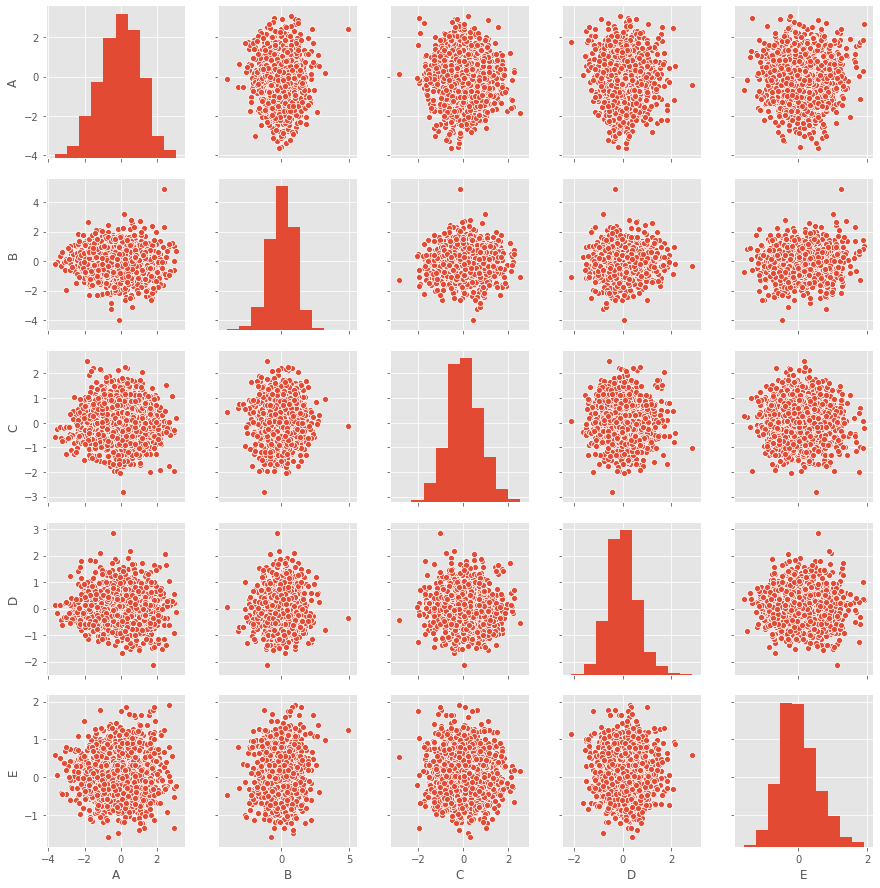

In [53]:
sns.pairplot(X)

In [54]:
def corr_heatmap(df):
    sns.set(style="white")

    # Generate a large random dataset
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

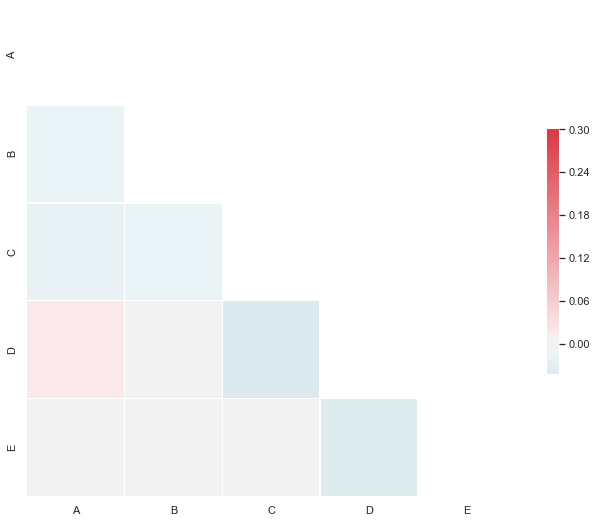

In [55]:
corr_heatmap(X)

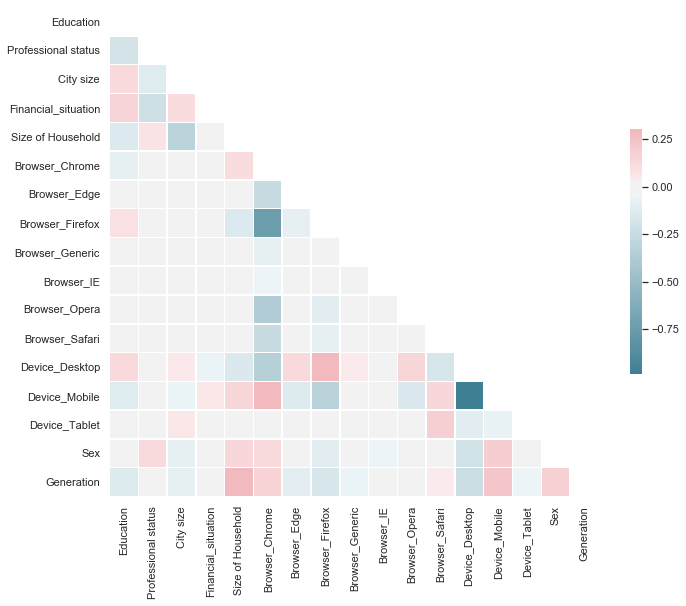

In [56]:
corr_heatmap(Y)

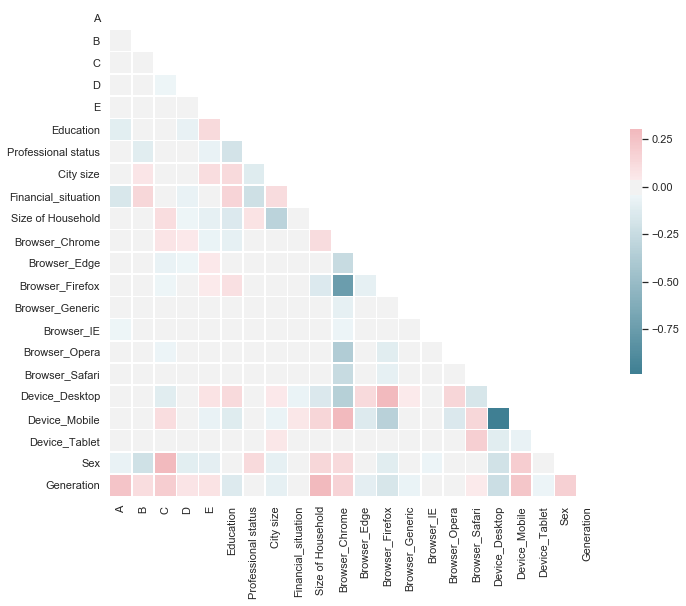

In [57]:
corr_heatmap(df.drop(['UserIdentifier'], axis=1))

#### Since we need to find the correlation between two sets of variables, then we can't use something like multiple-multiple regression. 

Instead we can use CCA is a multivariate method for comparing sets of continuous or catergorical variables to each other. It can be used (instead of multiple regression for example) when you suspect that the variables in the sets you're looking at are significantly correlated. Canonical correlation accounts for the idea of multi colinearity or covariance.

#### 1. Czy istnieje związek pomiędzy posiadanymi przez nas informacjami o ankietowanych, a ich profilem psychologicznym?

# ...

Hence, we are asking the question if there is a relationship between the user information based off their connected devices and personal status, and the users psychological profiles

In [58]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1, scale=True, max_iter=3000)

In [59]:
cca.fit(X, Y)

CCA(copy=True, max_iter=3000, n_components=1, scale=True, tol=1e-06)

In [60]:
X_c, Y_c = cca.transform(X, Y)

Text(0.5, 1.0, 'Comp. 1: X vs Y (test corr = 0.42)')

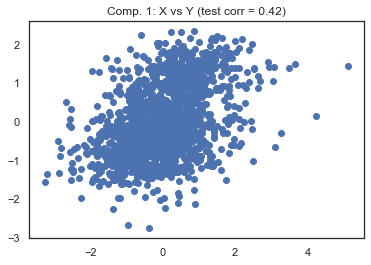

In [61]:
plt.scatter(X_c, Y_c)
plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
          np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])

##### hence we can see that there is a correlation between the two multivariate datasets

To get the significance ewe can perform the hapiro-Wilk test tests

In [62]:
from scipy import stats

In [63]:
shapiro_test = stats.shapiro(X_c[:, 0])
print(f"statistic {shapiro_test[0]}\t p-value {shapiro_test[0]}")

statistic 0.9943015575408936	 p-value 0.9943015575408936


In [64]:
cca.score(X, Y)

/usr/local/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-0.011615187904775401

### redundancy analysis

when we have results, we get structural coefficients. Here we can see the influence of each of the variables on the cross-variate relationship

In [65]:
x_load = pd.DataFrame(cca.x_loadings_).T
x_load.columns = list(X.columns)
x_load.T

,0
A,0.434409
B,0.606848
C,-0.411850
D,0.333453
E,0.404628


In [66]:
y_load = pd.DataFrame(cca.y_loadings_).T
y_load.columns = list(Y.columns)
y_load.T

,0
Education,0.023099
Professional status,-0.236581
City size,0.245760
Financial_situation,0.040278
Size of Household,-0.155625
Browser_Chrome,-0.056857
Browser_Edge,0.022917
Browser_Firefox,-0.001908
Browser_Generic,-0.076389
Browser_IE,0.005055


2. Czy możemy podzielić ankietowanych na grupy osób o podobnym profilu psychologicznym? Jakie to grupy, co wyróżnia każdą z nich, jaka jest ich charakterystyka demograficzna?

#### Hence from this we can deduce that the generation to which a user belongs has the biggest influence over their psychological profile and certaintly NOT their Professional status.

#### These groups that differ in psycogoical status are seperated by the generation they belong to, in other words the range of years they were born in. Therefore age has significant influence over mentality.

In [67]:
extracted = df[['A', 'B', 'C', 'D', 'E']]
y = df['Generation']

In [68]:
labels = df['Generation'].apply(lambda x: next((k for k, v in year_of_birth_mapper_to_numerical.items() if x==v), 0)).values

In [69]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [70]:
np.unique(labels)

array(['other', 'pokolenie BB', 'pokolenie X', 'pokolenie Y',
       'pokolenie Z'], dtype=object)

# T-sne decomposition for showing clusters in 2D (with the help of PCA).
# Generation vs Psychological profile
Psychological profile

In [73]:
use_PCA=True

Cumulative explained variation for 50 principal components: 0.9095520084639066
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1521 samples in 0.001s...
[t-SNE] Computed neighbors for 1521 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1521
[t-SNE] Computed conditional probabilities for sample 1521 / 1521
[t-SNE] Mean sigma: 0.287199
[t-SNE] Computed conditional probabilities in 0.017s
[t-SNE] Iteration 50: error = 88.7054977, gradient norm = 0.0744248 (50 iterations in 0.382s)
[t-SNE] Iteration 100: error = 80.1457748, gradient norm = 0.0504973 (50 iterations in 0.289s)
[t-SNE] Iteration 150: error = 79.8825684, gradient norm = 0.0427549 (50 iterations in 0.225s)
[t-SNE] Iteration 200: error = 79.8631134, gradient norm = 0.0290232 (50 iterations in 0.236s)
[t-SNE] Iteration 250: error = 79.8726349, gradient norm = 0.0434448 (50 iterations in 0.255s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.872635
[t-SNE] Iterat

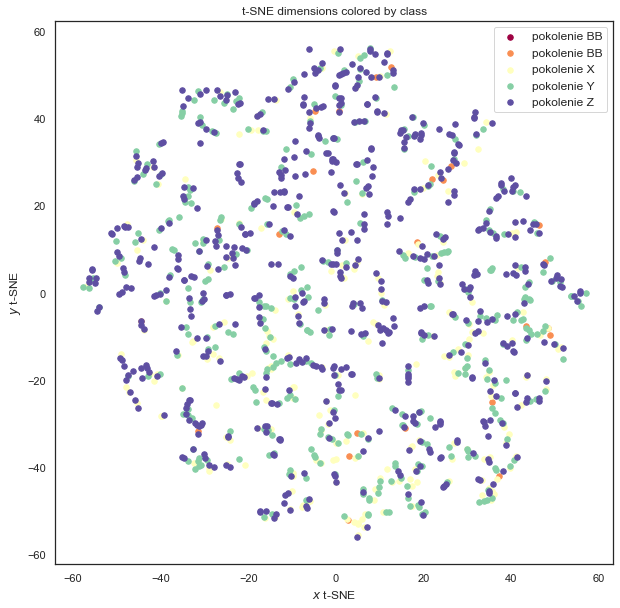

In [74]:
if use_PCA:
    pca_50 = PCA(n_components=4)
    extracted = pca_50.fit_transform(extracted)
    print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

# computing t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=3, perplexity=10, n_iter=500,learning_rate=200)
tsne_results = tsne.fit_transform(extracted)
print ("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

# plotting part
num_classes = len(np.unique(y))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
colors = cm.Spectral(np.linspace(0, 1, num_classes))

xx = tsne_results[:, 0]
yy = tsne_results[:, 1]

for i in range(num_classes):
    ax.scatter(xx[y==i], yy[y==i], color=colors[i], label=labels[i], s=30)

plt.title("t-SNE dimensions colored by class")
plt.axis('tight')
plt.legend(loc='best', scatterpoints=1, fontsize=10,prop={'size': 12})
# plt.savefig("presentation_images/t-sne"+type_+".png")
plt.xlabel('$x$ t-SNE')
plt.ylabel('$y$ t-SNE')
plt.show()

# Summary to the management

* we have analysed data of
    * Dataset 1: user profiles such Education, Professional status, City size, Financial_situation, Size of Household
    * Dataset 2: corresponding psychological profile information
* In terms of coding we have cleaned the data, converted "word-like" features (categorical) into "number-like" features (numerical) to be able to perform statistical tests

* We have found a correlation of 0.42  using between the two datasets using  Canonical Correlation Analysis.
* Canonical Correlation Analysis is a multivariate method for comparing sets of continuous or catergorical variables to each other
* The overwhelming influential factor which in the user features, which is responsible for the correlation of the two datasets is the generaton to which the user belongs to. Example: If they were born in the 60s or in the 80s.
* Hence we can see that we need to target groups and custom make ads to age groups instead of simply looking at variables such as wealth status, where they live etc.
